In [1]:
##Libraries
import numpy as np
import matplotlib.pyplot as plt

This is a Stock and flow model with just an intial state and three replacement types and how they replace equipment over time. We Are calculating Technical potential over time so all new equipment will be assumed to be the most efficient version

In [ ]:
def market_eq(
    Below_Baseline, Baseline, Efficient, Cumulative_adopters, par, retirement_rate,
    nc, nc_baseline_share, nc_efficient_share
):
    """
    This code will demonstate technical potential in a stock and flow system. THere are three different stock types. First is Market Driven - this market is a traditional turnover based market. 
    for the competition group we are modeling we will assume all conditions have the same EUL and turnover at 1/EUL rate. THe second market is Retrofit driven - This market will pull from the entire population stock evenly
    In this example we are ignoring the age of the equipment over time so the Retrofit market process is just a percentage of the entire stock (based on cost effectiveness) but for now we will just assume a 2 percent retrofit rate.
    The third market is New Construction - this market will be based on new additions to the stock. In this example we are assuming a fixed number of new construction units per year but this could be a time series input.
    """
    # New construction allocation
    nc_baseline = nc * nc_baseline_share
    nc_efficient = nc * nc_efficient_share
    nc_below_baseline = nc - nc_baseline - nc_efficient

    # Total stock before inflows
    total_stock = Below_Baseline + Baseline + Efficient

    # Retirement flow (all stocks retire at same rate)
    Retirement_Flow = total_stock * retirement_rate

    # Outflows (retirements) proportional to each stock
    out_Below_Baseline = -Retirement_Flow * (Below_Baseline / total_stock) if total_stock > 0 else 0
    out_Baseline = -Retirement_Flow * (Baseline / total_stock) if total_stock > 0 else 0
    out_Efficient = -Retirement_Flow * (Efficient / total_stock) if total_stock > 0 else 0

    # Inflows (adoptions + new construction)
    Efficient_Adoption_Flow = Retirement_Flow  # this will be the addition on retro fit and MD retirements for a given year
    Baseline_Adoption_Flow = 0 
    Below_Baseline_Adoption_Flow = 0

    # Euler differentials (inflow + NC - outflow)
    dBelow_Baseline_dt = nc_below_baseline + Below_Baseline_Adoption_Flow - (-out_Below_Baseline)
    dBaseline_dt = nc_baseline + Baseline_Adoption_Flow - (-out_Baseline)
    dEfficient_dt = nc_efficient + Efficient_Adoption_Flow - (-out_Efficient)

    flows = {
        "Retirement": Retirement_Flow,
        "Efficient_Adoption": Efficient_Adoption_Flow,
        "Baseline_Adoption": Baseline_Adoption_Flow,
        "out_Below_Baseline": out_Below_Baseline,
        "out_Baseline": out_Baseline,
        "out_Efficient": out_Efficient,
        "Cumulative_adopters": Cumulative_adopters
    }

    return dBelow_Baseline_dt, dBaseline_dt, dEfficient_dt, flows

   





In [3]:
# initalization and Parameters
total_years = 20
dt = 1/12
time = np.arange(0, total_years, dt)
n = len(time)
par = {"p": 0.03, "q": 0.38}
retirement_rate = 0.05
nc = 10  # new construction per year (can be array for time-varying)
nc_baseline_share = 0
nc_efficient_share = 1 # have these be an input that changes over time

# Initialize stocks
Below_Baseline_Stock = np.zeros(n)
Baseline_Stock = np.zeros(n)
Efficient_Stock = np.zeros(n)
Cumulative_adopters = np.zeros(n)

# Initial conditions
Below_Baseline_Stock[0] = 1000 * 0.3
Baseline_Stock[0] = 1000 * 0.5
Efficient_Stock[0] = 1000 * 0.2

# Initialize flow arrays for plotting
Retirement_Flow_arr = np.zeros(n)
Below_Baseline_Adoption_Flow_arr = np.zeros(n)
Baseline_Adoption_Flow_arr = np.zeros(n)
Efficient_Adoption_Flow_arr = np.zeros(n)
out_Below_Baseline_Adoption_Flow_arr = np.zeros(n)
out_Baseline_Adoption_Flow_arr = np.zeros(n)
out_Efficient_Adoption_Flow_arr = np.zeros(n)
Total_Below_Baseline_Adoption_Flow_arr = np.zeros(n)
Total_Baseline_Adoption_Flow_arr = np.zeros(n)
Total_Efficient_Adoption_Flow_arr = np.zeros(n)
Total_Adoption_Flow_arr = np.zeros(n)      
bass_share_arr = np.zeros(n)             
bass_value_arr = np.zeros(n)         

In [ ]:
# Euler Integration Loop
for t in range(1, n):
    dBelow_Baseline_dt, dBaseline_dt, dEfficient_dt, flows = market_eq(
        Below_Baseline_Stock[t-1],
        Baseline_Stock[t-1],
        Efficient_Stock[t-1],
        Cumulative_adopters[t-1],
        par,
        retirement_rate,
        nc * dt,  # new construction for this step
        nc_baseline_share,
        nc_efficient_share
    )

    # Euler integration
    Below_Baseline_Stock[t] = Below_Baseline_Stock[t-1] + dBelow_Baseline_dt
    Baseline_Stock[t] = Baseline_Stock[t-1] + dBaseline_dt
    Efficient_Stock[t] = Efficient_Stock[t-1] + dEfficient_dt

    # Enforce non-negativity
    Below_Baseline_Stock[t] = max(Below_Baseline_Stock[t], 0.0)
    Baseline_Stock[t] = max(Baseline_Stock[t], 0.0)
    Efficient_Stock[t] = max(Efficient_Stock[t], 0.0)


        # Log flows for plotting
    Retirement_Flow_arr[t] = flows["Retirement"]
    Below_Baseline_Adoption_Flow_arr[t] = 0  # No below baseline adoption in this model
    Baseline_Adoption_Flow_arr[t] = flows["Baseline_Adoption"]
    Efficient_Adoption_Flow_arr[t] = flows["Efficient_Adoption"]
    out_Below_Baseline_Adoption_Flow_arr[t] = flows["out_Below_Baseline"]
    out_Baseline_Adoption_Flow_arr[t] = flows["out_Baseline"]
    out_Efficient_Adoption_Flow_arr[t] = flows["out_Efficient"]
    Total_Below_Baseline_Adoption_Flow_arr[t] = dBelow_Baseline_dt
    Total_Baseline_Adoption_Flow_arr[t] = dBaseline_dt
    Total_Efficient_Adoption_Flow_arr[t] = dEfficient_dt
    Total_Adoption_Flow_arr[t] = flows["Efficient_Adoption"] + flows["Baseline_Adoption"]  # Or Retirement_Flow



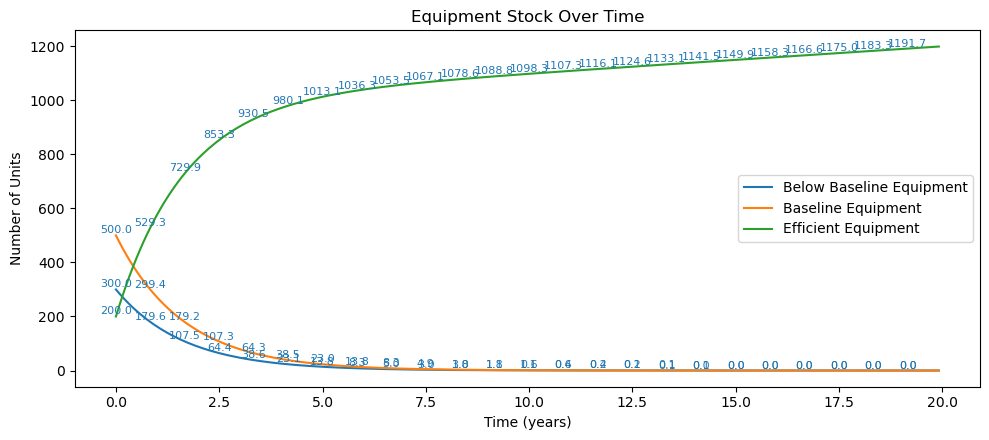

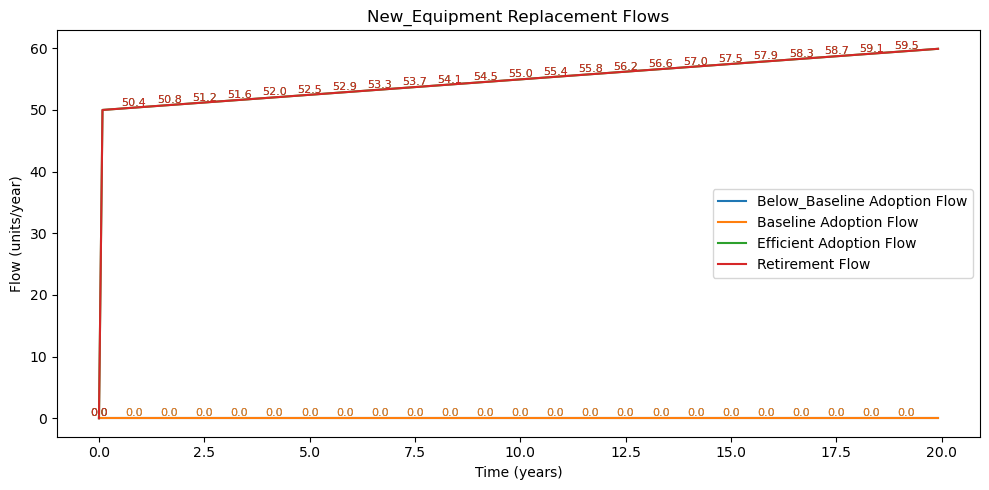

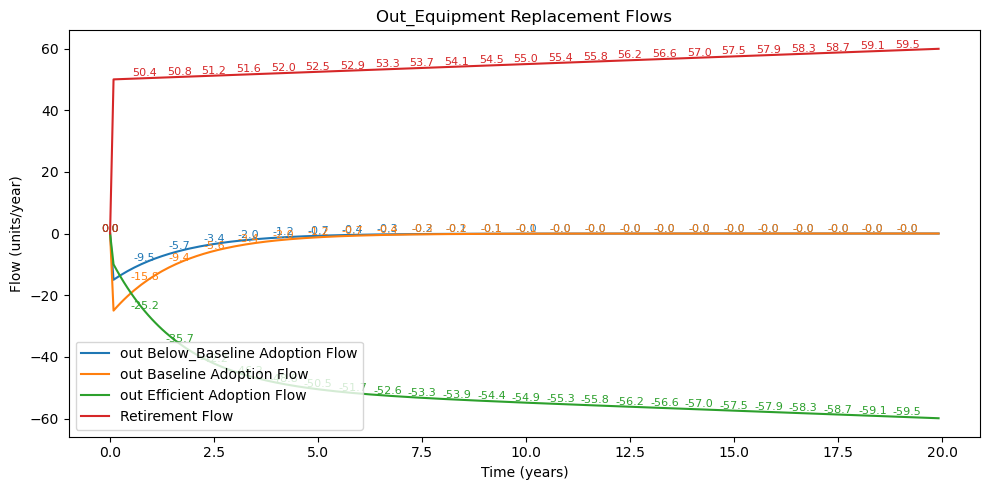

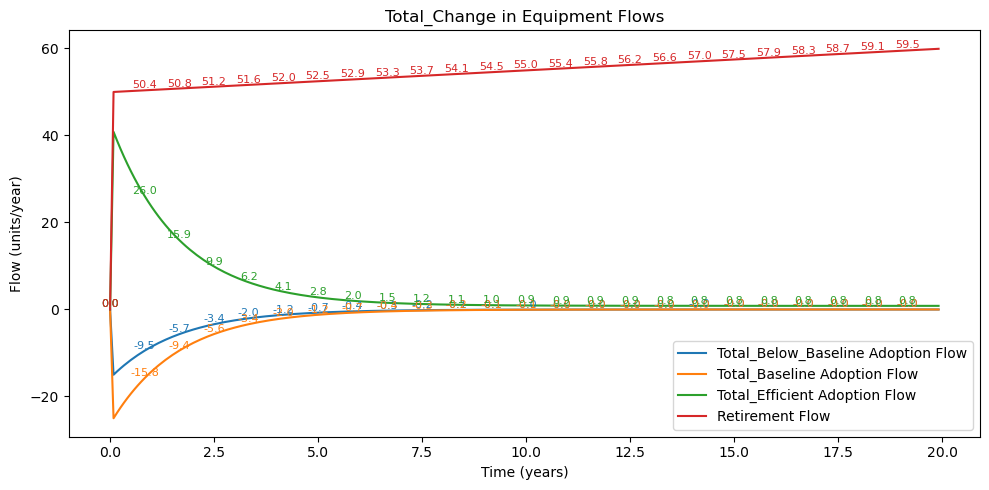

In [6]:
# Equipment Stocks
plt.figure(figsize=(10, 4.5))
plt.plot(time, Below_Baseline_Stock, label="Below Baseline Equipment")
plt.plot(time, Baseline_Stock, label="Baseline Equipment")
plt.plot(time, Efficient_Stock, label="Efficient Equipment")
for i in range(0, len(time), 10):
    plt.text(time[i], Efficient_Stock[i], f"{Efficient_Stock[i]:.1f}", 
             fontsize=8, ha='center', va='bottom', color='tab:blue')
    plt.text(time[i], Baseline_Stock[i], f"{Baseline_Stock[i]:.1f}", 
             fontsize=8, ha='center', va='bottom', color='tab:blue')
    plt.text(time[i], Below_Baseline_Stock[i], f"{Below_Baseline_Stock[i]:.1f}", 
             fontsize=8, ha='center', va='bottom', color='tab:blue')
plt.xlabel("Time (years)")
plt.ylabel("Number of Units")
plt.title("Equipment Stock Over Time")
plt.legend()
plt.tight_layout()
plt.show()

# New Equipment Flows
plt.figure(figsize=(10, 5))
plt.plot(time, Below_Baseline_Adoption_Flow_arr, label="Below_Baseline Adoption Flow")
plt.plot(time, Baseline_Adoption_Flow_arr, label="Baseline Adoption Flow")
plt.plot(time, Efficient_Adoption_Flow_arr, label="Efficient Adoption Flow")
plt.plot(time, Retirement_Flow_arr, label="Retirement Flow")

for i in range(0, len(time), 10):
    plt.text(time[i], Below_Baseline_Adoption_Flow_arr[i], f"{Below_Baseline_Adoption_Flow_arr[i]:.1f}", 
             fontsize=8, ha='center', va='bottom', color='tab:blue')
    plt.text(time[i], Baseline_Adoption_Flow_arr[i], f"{Baseline_Adoption_Flow_arr[i]:.1f}", 
             fontsize=8, ha='center', va='bottom', color='tab:orange')
    plt.text(time[i], Efficient_Adoption_Flow_arr[i], f"{Efficient_Adoption_Flow_arr[i]:.1f}", 
             fontsize=8, ha='center', va='bottom', color='tab:green')
    plt.text(time[i], Retirement_Flow_arr[i], f"{Retirement_Flow_arr[i]:.1f}", 
             fontsize=8, ha='center', va='bottom', color='tab:red')

plt.xlabel("Time (years)")
plt.ylabel("Flow (units/year)")
plt.title("New_Equipment Replacement Flows")
plt.legend()
plt.tight_layout()
plt.show()

# out Equipment Flows
plt.figure(figsize=(10, 5))
plt.plot(time, out_Below_Baseline_Adoption_Flow_arr, label="out Below_Baseline Adoption Flow")
plt.plot(time, out_Baseline_Adoption_Flow_arr, label="out Baseline Adoption Flow")
plt.plot(time, out_Efficient_Adoption_Flow_arr, label="out Efficient Adoption Flow")
plt.plot(time, Retirement_Flow_arr, label="Retirement Flow")

for i in range(0, len(time), 10):
    plt.text(time[i], out_Below_Baseline_Adoption_Flow_arr[i], f"{out_Below_Baseline_Adoption_Flow_arr[i]:.1f}", 
             fontsize=8, ha='center', va='bottom', color='tab:blue')
    plt.text(time[i], out_Baseline_Adoption_Flow_arr[i], f"{out_Baseline_Adoption_Flow_arr[i]:.1f}", 
             fontsize=8, ha='center', va='bottom', color='tab:orange')
    plt.text(time[i], out_Efficient_Adoption_Flow_arr[i], f"{out_Efficient_Adoption_Flow_arr[i]:.1f}", 
             fontsize=8, ha='center', va='bottom', color='tab:green')
    plt.text(time[i], Retirement_Flow_arr[i], f"{Retirement_Flow_arr[i]:.1f}", 
             fontsize=8, ha='center', va='bottom', color='tab:red')

plt.xlabel("Time (years)")
plt.ylabel("Flow (units/year)")
plt.title("Out_Equipment Replacement Flows")
plt.legend()
plt.tight_layout()
plt.show()

# Total Equipment Flows
plt.figure(figsize=(10, 5))
plt.plot(time, Total_Below_Baseline_Adoption_Flow_arr, label="Total_Below_Baseline Adoption Flow")
plt.plot(time, Total_Baseline_Adoption_Flow_arr, label="Total_Baseline Adoption Flow")
plt.plot(time, Total_Efficient_Adoption_Flow_arr, label="Total_Efficient Adoption Flow")
plt.plot(time, Retirement_Flow_arr, label="Retirement Flow")

for i in range(0, len(time), 10):
    plt.text(time[i], Total_Below_Baseline_Adoption_Flow_arr[i], f"{Total_Below_Baseline_Adoption_Flow_arr[i]:.1f}", 
             fontsize=8, ha='center', va='bottom', color='tab:blue')
    plt.text(time[i], Total_Baseline_Adoption_Flow_arr[i], f"{Total_Baseline_Adoption_Flow_arr[i]:.1f}", 
             fontsize=8, ha='center', va='bottom', color='tab:orange')
    plt.text(time[i], Total_Efficient_Adoption_Flow_arr[i], f"{Total_Efficient_Adoption_Flow_arr[i]:.1f}", 
             fontsize=8, ha='center', va='bottom', color='tab:green')
    plt.text(time[i], Retirement_Flow_arr[i], f"{Retirement_Flow_arr[i]:.1f}", 
             fontsize=8, ha='center', va='bottom', color='tab:red')

plt.xlabel("Time (years)")
plt.ylabel("Flow (units/year)")
plt.title("Total_Change in Equipment Flows")
plt.legend()
plt.tight_layout()
plt.show()
